# Domain adaptation analysis

## Initial settings

#### Dependencies

In [1]:
%pip install --user -qr ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import and Utilities

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics import Accuracy
from torchvision import transforms
import torchvision.models as models

import torchmetrics

from matplotlib import pyplot as plt

import os
import numpy as np

import copy

## Dataset Pre Analysis

In [2]:
from scripts.dataset.data_module import CulturalSiteDataModule

dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


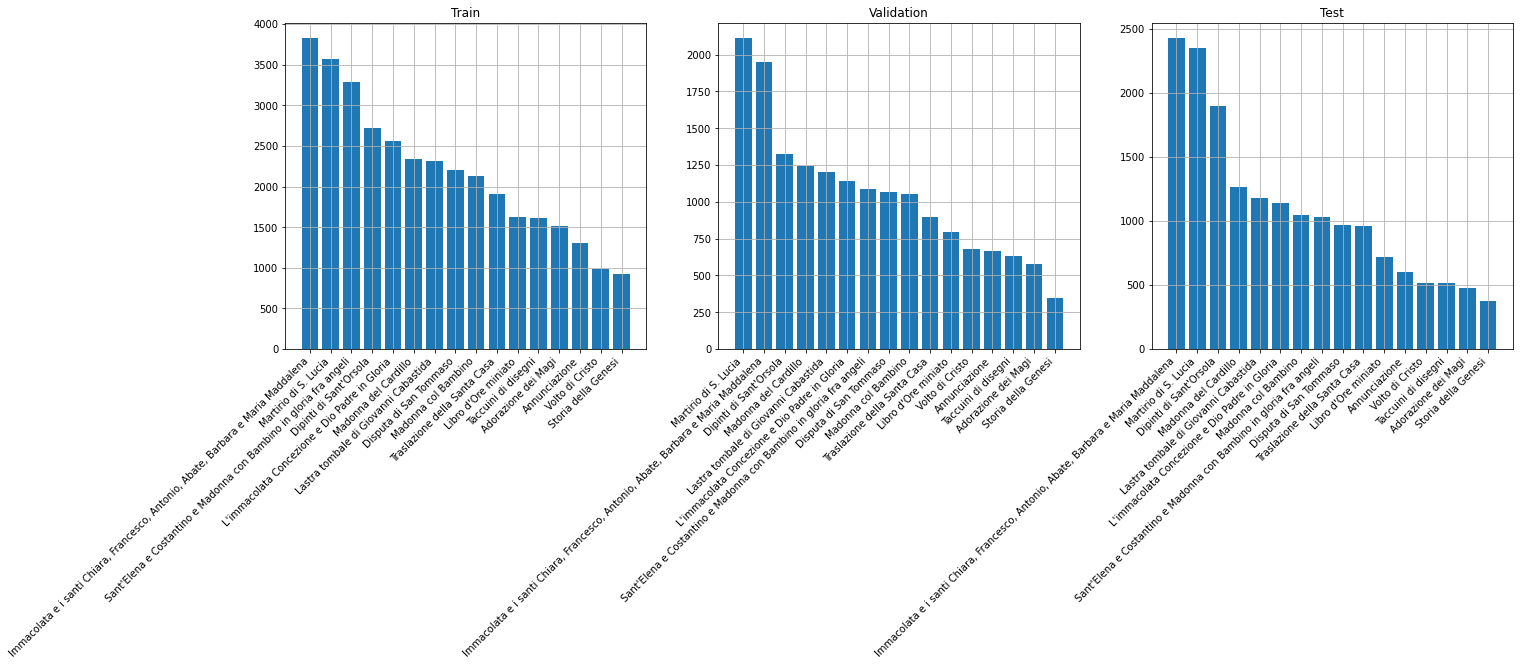

In [5]:
fig, (train_subplot, val_subplot, test_subplot) = plt.subplots(1, 3)
dm.train_preanalysis(train_subplot, 'Train')
dm.val_preanalysis(val_subplot, 'Validation')
dm.test_preanalysis(test_subplot, 'Test')
fig.set_size_inches(22, 6)
plt.show()

## Filtering study case

Si è notato che alcune patches estratte dal dataset originale consistono in un insieme di pixel che non rispecchiano a prima vista l'immagine rappresentata. Si vuole dunque porre in analisi i casi di studio per cui:
1) Training effettuato sul dataset non filtrato
2) Training effettuato sul dataset filtrato (rimosse patches con meno di 30 pixel per lato)

Se ne analizzano i risultati ottenuti.

#### Model

In [9]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.accuracy = Accuracy()

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    # TODO: da implementare come furnari, permetter un calcolo più preciso dell'accuracy
    # def validation_epoch_end(self, outputs):
    #     #concateniamo tutte le predizioni 
    #     predictions = np.concatenate([o['predictions'] for o in outputs])
    #     #concateniamo tutte le etichette
    #     labels = np.concatenate([o['labels'] for o in outputs])
        
    #     acc = accuracy_score(labels, predictions)
        
    #     self.log('val/accuracy', acc

In [3]:
class ResNet50Model(pl.LightningModule):
    
    def __init__(self, pretrained=False, in_channels = 3, num_classes = 16, lr=1e-3, momentum=0):
        super(ResNet50Model, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.lr = lr
        self.momentum = momentum
        
        self.model = models.resnet50(pretrained=pretrained)
        
        if pretrained is True:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.Dropout(0.5),
            nn.Linear(512, self.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):        
        x, y = batch        
        preds = self.model(x)        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.model(x)        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.model(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

    # def validation_epoch_end(self, outputs): #? forse non necessaria, on_epoch=True stampa valori accumulati per epoca
    #     #concateniamo tutte le predizioni 
    #     predictions = np.concatenate([o['predictions'] for o in outputs])
    #     #concateniamo tutte le etichette
    #     labels = np.concatenate([o['labels'] for o in outputs])
        
    #     acc = self.val_acc(labels, predictions)
        
    #     self.log('val/accuracy', self.val_acc)

#### Resize input features

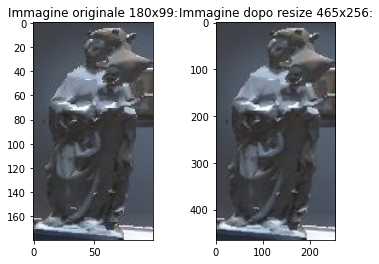

In [17]:
from PIL import Image

min_size = 256
prev_image = dm.cultural_site_train.get_image_dataset()[0][1]
img = Image.fromarray(prev_image)
aspect = img.width / img.height if img.width > img.height else img.height / img.width   
post_image = np.asarray(img.resize((int(min_size * aspect), min_size), Image.Resampling.BICUBIC) if img.width > img.height else img.resize((min_size, int(min_size * aspect)), Image.Resampling.BICUBIC))                
_, (prev_subplot, post_subplot) = plt.subplots(1, 2)
prev_subplot.set_title("Immagine originale " + str(prev_image.shape[0]) + "x" + str(prev_image.shape[1]) + ":")
post_subplot.set_title("Immagine dopo resize " + str(post_image.shape[0]) + "x" + str(post_image.shape[1]) + ":")
prev_subplot.imshow(prev_image)
post_subplot.imshow(post_image) 

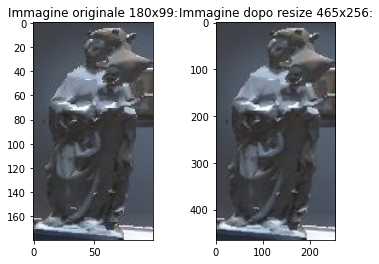

In [4]:
min_size = 256
dm.resize_train(min_size)
dm.resize_val(min_size)
dm.resize_test(min_size)

### Data Augmentations

In [ ]:
mean, std = dm.calculate_train_mean_and_std()
print("Mean squared error: " + str(mean))
print("Standard deviation: " + str(std))

In [8]:

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),             # In fase di test, applichiamo una trasformazione simile ma sostituiamo RandomCrop con CenterCrop . Questo in pratica
                                            # serve a far sì che la fase di test sia sempre deterministica.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

Mean squared error: [0.27874559 0.28939785 0.31436918]
Standard deviation: [0.16007521 0.16557982 0.16824701]


In [9]:
#model = LitModel((3, 32, 32), dm.num_classes)
model = ResNet50Model(num_classes=16)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="no_filter_train")

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=100,
                     accelerator="gpu", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     gpus=1,
                     devices=1,
                     logger=logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# Evaluate the model on the held-out test set 
trainer.test(dataloaders=dm.test_dataloader())

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:466: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\no_filter_train


Classification dataset found.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at tb_logs\no_filter_train\version_0\checkpoints\epoch=7-step=8712.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at tb_logs\no_filter_train\version_0\checkpoints\epoch=7-step=8712.ckpt


Classification dataset found.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9383655786514282
        test_loss           0.22735732793807983
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22735732793807983, 'test_acc': 0.9383655786514282}]

### Caso 2: Training effettuato sul dataset filtrato

Si è notato che alcune immagini non rapresetavano pienamente le caratteristiche dell'oggetto da classificare, per cui si è optato di scartare le immaggini con meno di 30px per lato.

In [3]:
filtered_dataset_dm = copy.deepcopy(dm)

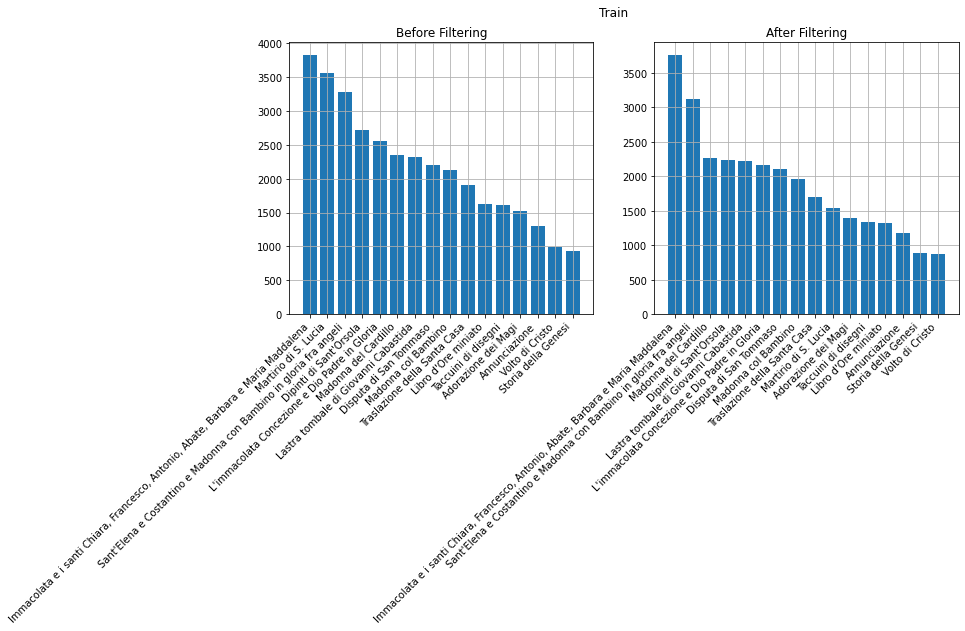

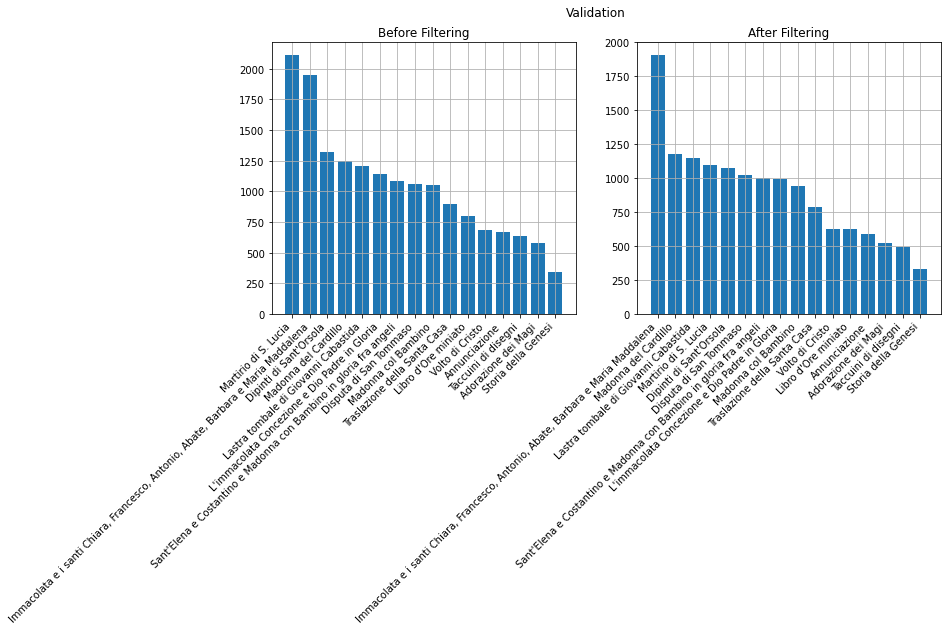

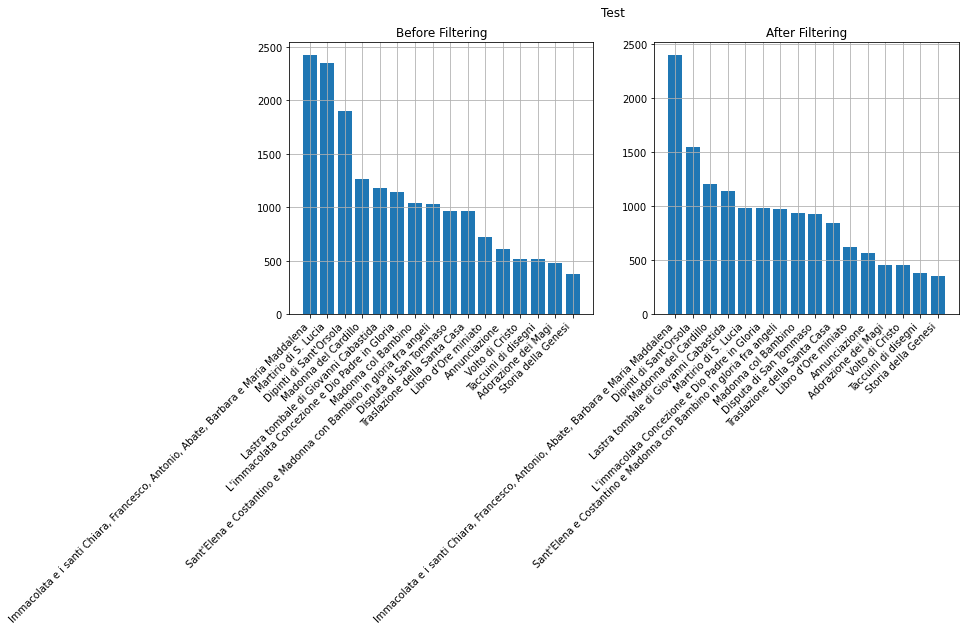

In [4]:
soglia_pixel = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
filtered_dataset_dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
filtered_dataset_dm.filter_train(soglia_pixel)
filtered_dataset_dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
filtered_dataset_dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
filtered_dataset_dm.filter_val(soglia_pixel)
filtered_dataset_dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
filtered_dataset_dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
filtered_dataset_dm.filter_test(soglia_pixel)
filtered_dataset_dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

### Resize input features

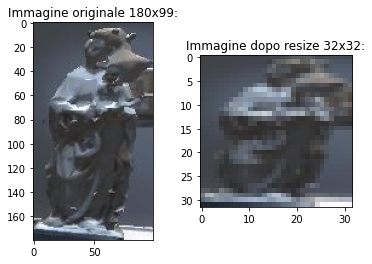

In [6]:
filtered_dataset_dm.resize_train()
filtered_dataset_dm.resize_val()
filtered_dataset_dm.resize_test()

### Normalize input feature

In [7]:
filtered_dataset_dm.set_normalization_to_datasets()

Mean squared error: [0.28153971 0.29229286 0.31700209]
Standard deviation: [0.16335081 0.16930279 0.17219641]


In [10]:
model = LitModel((3, 32, 32), filtered_dataset_dm.num_classes)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="filtered_train")

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=100,
                     accelerator="gpu", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     gpus=1,
                     devices=1,
                     logger=logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, filtered_dataset_dm)

# Evaluate the model on the held-out test set 
trainer.test(dataloaders=filtered_dataset_dm.test_dataloader())

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:466: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\filtered_train


Classification dataset found.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at tb_logs\filtered_train\version_0\checkpoints\epoch=9-step=9390.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at tb_logs\filtered_train\version_0\checkpoints\epoch=9-step=9390.ckpt


Classification dataset found.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9629956483840942
        test_loss           0.14040954411029816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.14040954411029816, 'test_acc': 0.9629956483840942}]

TODO: mettere considerazioni, ad esempio quale dei due percorsi si è optato, se considerare il dataset filtrato o quello originale per lo studio

Per ora abbiamo constatato che il filtro migliora di poco sia loss che accuracy

## Domain adaptation study cases

### 1. Baseline approaches without adaption
Il primo caso di studio è quello di allenare il classificatore sul sintetico e poi testarlo nudo e crudo sul reale, valutare le performance

### Classification Module

In [10]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.accuracy = Accuracy()

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    # TODO: da implementare come furnari, permetter un calcolo più preciso dell'accuracy
    # def validation_epoch_end(self, outputs):
    #     #concateniamo tutte le predizioni 
    #     predictions = np.concatenate([o['predictions'] for o in outputs])
    #     #concateniamo tutte le etichette
    #     labels = np.concatenate([o['labels'] for o in outputs])
        
    #     acc = accuracy_score(labels, predictions)
        
    #     self.log('val/accuracy', acc


### Model Training

#### 1)  the model is trained on synthetic images and tested on synthetic images (no domain shift)

In [11]:
model = LitModel((3, 32, 32), dm.num_classes)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=100,
                     # accelerator="mps", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     gpus=1,
                     devices=1,
                     logger=logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# Evaluate the model on the held-out test set 
trainer.test(dataloaders=dm.test_dataloader())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Classification dataset found.


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_7\checkpoints\epoch=9-step=9390.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_7\checkpoints\epoch=9-step=9390.ckpt



Classification dataset found.


c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9473791122436523
        test_loss           0.1824977546930313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1824977546930313, 'test_acc': 0.9473791122436523}]

In [12]:
%reload_ext tensorboard
%tensorboard --logdir=tb_logs/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

####  2) the model is trained on synthetic images and tested on real images (no adaptation)

In [13]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.REAL_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

Classification dataset found.


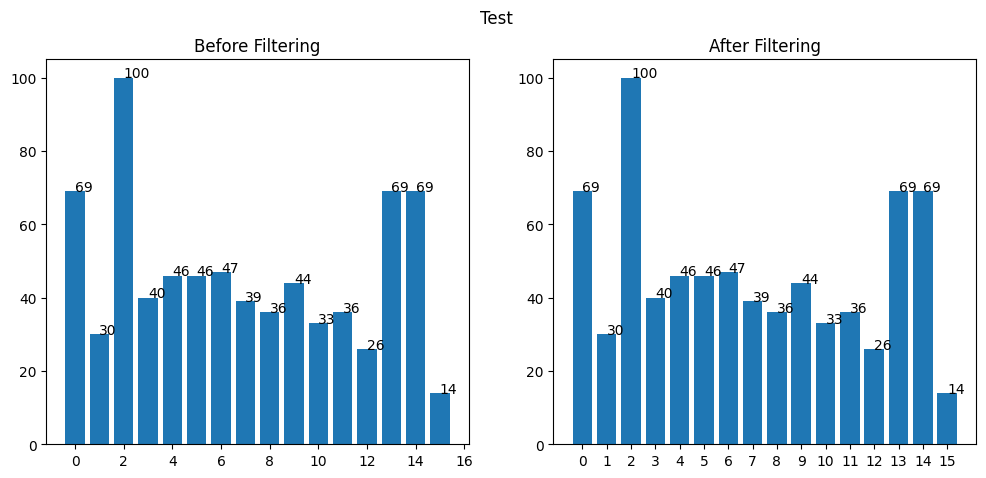

In [15]:
test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test()
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

dm.normalize_test()

In [16]:
trainer.test(dataloaders=dm.test_dataloader())

Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_3\checkpoints\epoch=9-step=9390.ckpt
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_3\checkpoints\epoch=9-step=9390.ckpt


Classification dataset found.
Testing: 0it [04:30, ?it/s]
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 85.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.11559139937162399
        test_loss            28.88227653503418
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 28.88227653503418, 'test_acc': 0.11559139937162399}]

 #### 3) the model is trained on real images and tested on real images

In [18]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.REAL_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


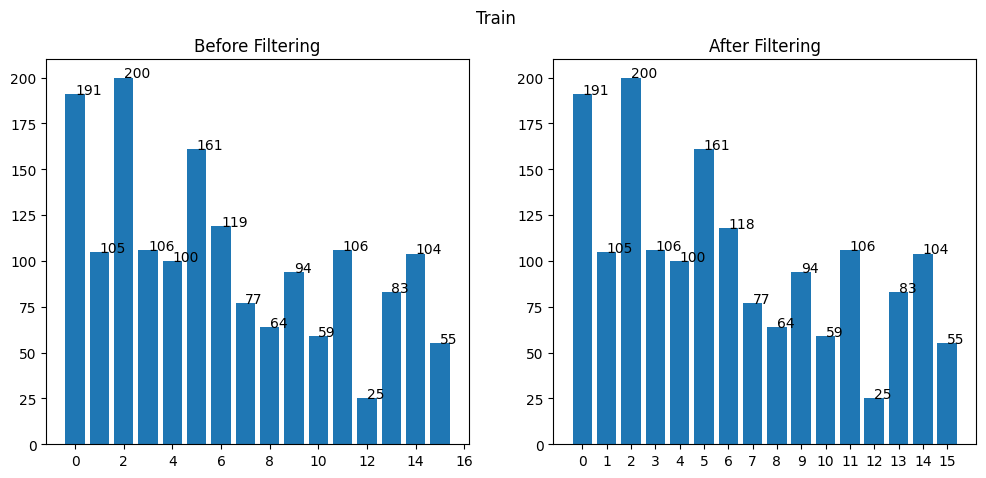

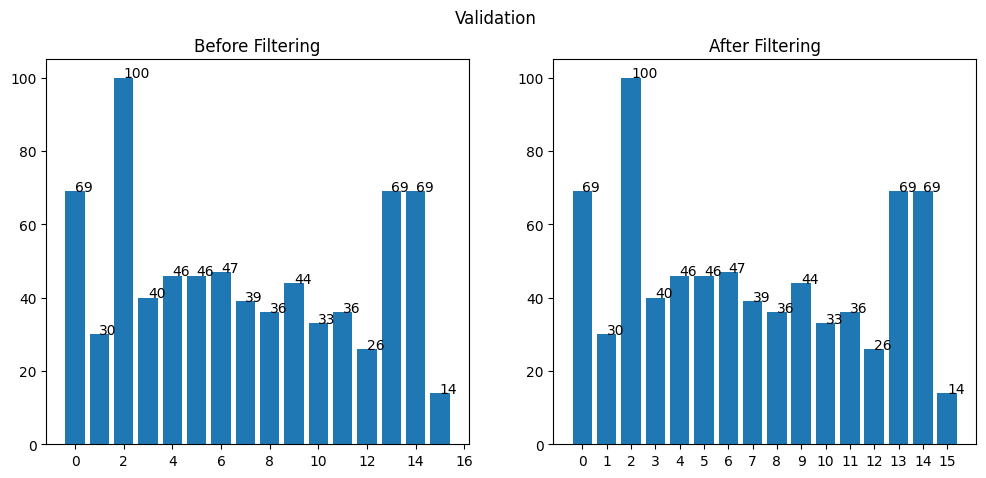

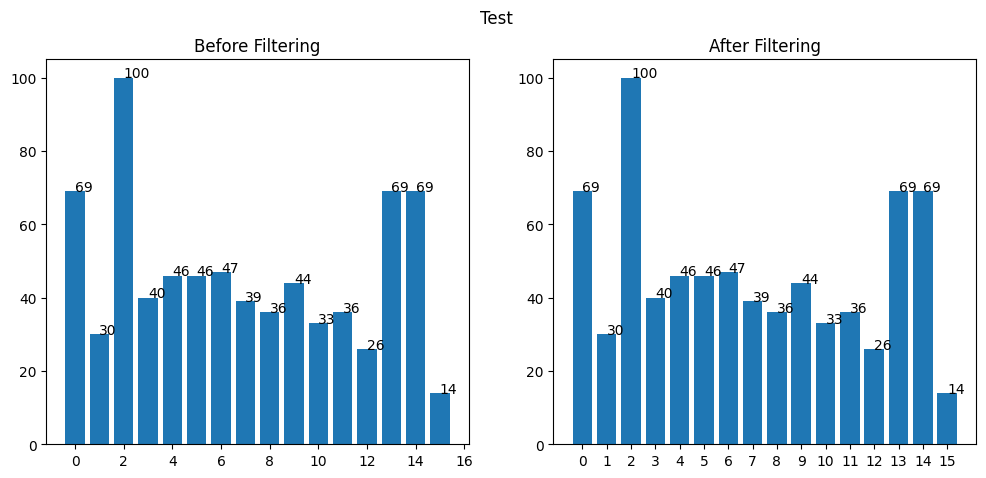

In [19]:
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train()
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val()
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test()
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

plt.show()

In [22]:
model = LitModel((3, 32, 32), dm.num_classes)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=100,
                     # accelerator="mps", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     gpus=1,
                     devices=1,
                     logger=logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# Evaluate the model on the held-out test set 
trainer.test(dataloaders=dm.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Classification dataset found.
Epoch 26: 100%|██████████| 76/76 [00:02<00:00, 34.46it/s, loss=0.426, v_num=5, val_loss=1.100, val_acc=0.726]

Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_5\checkpoints\epoch=26-step=1404.ckpt
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_5\checkpoints\epoch=26-step=1404.ckpt



Classification dataset found.
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 82.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.725806474685669
        test_loss            1.098347544670105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.098347544670105, 'test_acc': 0.725806474685669}]

In [33]:
im = Image.open("E:/github/deep-learning-project/CLASS-EGO-CH-OBJ-ADAPT/real/test/data/000001.jpg").resize((CulturalSiteDataset.RESIZE_WIDTH, CulturalSiteDataset.RESIZE_HEIGHT))
pl.imgshow(im)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Todo: controllare questa normalizzazione (zero mean normalizzation)
])
img = transform(im)
print(model.forward(img))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x25 and 1600x512)